# Data

In [5]:
from pathlib import Path

DATA_RAW = Path.cwd().parent / "data" / "raw"
list(DATA_RAW.iterdir())


[WindowsPath('c:/Users/1/Desktop/VS Code Projects/student-performance-inference/data/raw/student-mat.csv')]

In [6]:
import pandas as pd

df = pd.read_csv(DATA_RAW / "student-mat.csv", sep=";")
df.shape


(395, 33)

In [7]:
import numpy as np
import matplotlib.pyplot as plt

PROJECT_ROOT = Path.cwd().parent
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
FIG_DIR = PROJECT_ROOT / "reports" / "figures"
TAB_DIR = PROJECT_ROOT / "reports" / "tables"

for d in [DATA_PROCESSED, FIG_DIR, TAB_DIR]:
    d.mkdir(parents=True, exist_ok=True)

PROJECT_ROOT


WindowsPath('c:/Users/1/Desktop/VS Code Projects/student-performance-inference')

# Examine

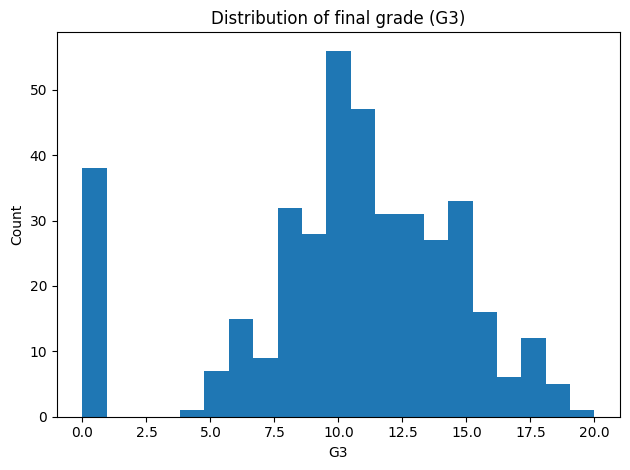

Saved: c:\Users\1\Desktop\VS Code Projects\student-performance-inference\reports\figures\g3_hist.png


In [8]:
fig, ax = plt.subplots()
ax.hist(df["G3"], bins=21)
ax.set(title="Distribution of final grade (G3)", xlabel="G3", ylabel="Count")
fig.tight_layout()
fig.savefig(FIG_DIR / "g3_hist.png", dpi=200)
plt.show()

print("Saved:", FIG_DIR / "g3_hist.png")


In [9]:
df = df.copy()

OUTCOME = "G3"

# Ordered categorical variables (primary analysis treats these as ordered factors)
ordered_vars = {
    "studytime": [1, 2, 3, 4],
    "failures":  [0, 1, 2, 3],
    "famrel":    [1, 2, 3, 4, 5],
    "freetime":  [1, 2, 3, 4, 5],
    "goout":     [1, 2, 3, 4, 5],
    "Dalc":      [1, 2, 3, 4, 5],
    "Walc":      [1, 2, 3, 4, 5],
    "health":    [1, 2, 3, 4, 5],
}

for v, cats in ordered_vars.items():
    df[v] = pd.Categorical(df[v], categories=cats, ordered=True)

# Binary variables as category
binary_vars = ["sex", "address", "famsup", "paid", "schoolsup", "higher", "internet", "romantic"]
for v in binary_vars:
    df[v] = df[v].astype("category")

# Nominal categories
nominal_vars = ["school", "Mjob", "Fjob", "reason", "guardian"]
for v in nominal_vars:
    df[v] = df[v].astype("category")

df.dtypes.head(15), df[OUTCOME].describe()


(school        category
 sex           category
 age              int64
 address       category
 famsize         object
 Pstatus         object
 Medu             int64
 Fedu             int64
 Mjob          category
 Fjob          category
 reason        category
 guardian      category
 traveltime       int64
 studytime     category
 failures      category
 dtype: object,
 count    395.000000
 mean      10.415190
 std        4.581443
 min        0.000000
 25%        8.000000
 50%       11.000000
 75%       14.000000
 max       20.000000
 Name: G3, dtype: float64)

# First hypothesis test (sex difference in G3) with uncertainty

In [10]:
import scipy.stats as st

RNG = np.random.default_rng(42)

def cohens_d(x, y):
    x = np.asarray(x, dtype=float); y = np.asarray(y, dtype=float)
    x = x[~np.isnan(x)]; y = y[~np.isnan(y)]
    nx, ny = len(x), len(y)
    sx, sy = x.std(ddof=1), y.std(ddof=1)
    sp = np.sqrt(((nx-1)*sx**2 + (ny-1)*sy**2) / (nx+ny-2))
    return (x.mean() - y.mean()) / sp

def bootstrap_mean_diff(x, y, B=5000, alpha=0.05, rng=None):
    rng = RNG if rng is None else rng
    x = np.asarray(x, dtype=float); y = np.asarray(y, dtype=float)
    x = x[~np.isnan(x)]; y = y[~np.isnan(y)]
    nx, ny = len(x), len(y)
    diffs = np.empty(B)
    for b in range(B):
        xb = rng.choice(x, size=nx, replace=True)
        yb = rng.choice(y, size=ny, replace=True)
        diffs[b] = xb.mean() - yb.mean()
    lo, hi = np.quantile(diffs, [alpha/2, 1-alpha/2])
    return lo, hi

def permutation_pvalue_mean_diff(x, y, B=20000, rng=None):
    rng = RNG if rng is None else rng
    x = np.asarray(x, dtype=float); y = np.asarray(y, dtype=float)
    x = x[~np.isnan(x)]; y = y[~np.isnan(y)]
    obs = x.mean() - y.mean()
    pooled = np.concatenate([x, y])
    nx = len(x)
    count = 0
    for _ in range(B):
        rng.shuffle(pooled)
        diff = pooled[:nx].mean() - pooled[nx:].mean()
        if abs(diff) >= abs(obs):
            count += 1
    return obs, (count + 1) / (B + 1)

def welch_ci_mean_diff(x, y, alpha=0.05):
    x = np.asarray(x, dtype=float); y = np.asarray(y, dtype=float)
    x = x[~np.isnan(x)]; y = y[~np.isnan(y)]
    mx, my = x.mean(), y.mean()
    vx, vy = x.var(ddof=1), y.var(ddof=1)
    nx, ny = len(x), len(y)
    diff = mx - my
    se = np.sqrt(vx/nx + vy/ny)
    df_w = (vx/nx + vy/ny)**2 / ((vx/nx)**2/(nx-1) + (vy/ny)**2/(ny-1))
    tcrit = st.t.ppf(1 - alpha/2, df_w)
    return diff, diff - tcrit*se, diff + tcrit*se

# Compare female vs male (categories are usually 'F' and 'M')
cats = list(df["sex"].cat.categories)
a, b = cats[0], cats[1]

xa = df.loc[df["sex"] == a, OUTCOME].to_numpy()
xb = df.loc[df["sex"] == b, OUTCOME].to_numpy()

tstat, p_welch = st.ttest_ind(xa, xb, equal_var=False, nan_policy="omit")
diff, ci_lo, ci_hi = welch_ci_mean_diff(xa, xb)
boot_lo, boot_hi = bootstrap_mean_diff(xa, xb, B=5000)
obs_perm, p_perm = permutation_pvalue_mean_diff(xa, xb, B=20000)
d = cohens_d(xa, xb)

result_sex = pd.DataFrame([{
    "comparison": f"{a} - {b}",
    "mean_"+str(a): np.nanmean(xa),
    "mean_"+str(b): np.nanmean(xb),
    "diff_mean": diff,
    "ci95_welch_lo": ci_lo,
    "ci95_welch_hi": ci_hi,
    "p_welch": p_welch,
    "cohens_d": d,
    "ci95_boot_lo": boot_lo,
    "ci95_boot_hi": boot_hi,
    "p_perm": p_perm,
    "n_"+str(a): int(np.sum(~np.isnan(xa))),
    "n_"+str(b): int(np.sum(~np.isnan(xb))),
}])

result_sex


,comparison,mean_F,mean_M,diff_mean,ci95_welch_lo,ci95_welch_hi,p_welch,cohens_d,ci95_boot_lo,ci95_boot_hi,p_perm,n_F,n_M
0,F - M,9.966346,10.914439,-0.948092,-1.850732,-0.045452,0.039577,-0.207794,-1.833222,-0.05953,0.041248,208,187


In [11]:
result_sex.to_csv(TAB_DIR / "t_test_sex_g3.csv", index=False)
print("Saved:", TAB_DIR / "t_test_sex_g3.csv")


Saved: c:\Users\1\Desktop\VS Code Projects\student-performance-inference\reports\tables\t_test_sex_g3.csv


# Second hypothesis test (internet access difference in G3) with uncertainty

In [12]:
# Compare female vs male (categories are usually 'F' and 'M')
cats = list(df["internet"].cat.categories)
a, b = cats[0], cats[1]

xa = df.loc[df["internet"] == a, OUTCOME].to_numpy()
xb = df.loc[df["internet"] == b, OUTCOME].to_numpy()

tstat, p_welch = st.ttest_ind(xa, xb, equal_var=False, nan_policy="omit")
diff, ci_lo, ci_hi = welch_ci_mean_diff(xa, xb)
boot_lo, boot_hi = bootstrap_mean_diff(xa, xb, B=5000)
obs_perm, p_perm = permutation_pvalue_mean_diff(xa, xb, B=20000)
d = cohens_d(xa, xb)

result_internet = pd.DataFrame([{
    "comparison": f"{a} - {b}",
    "mean_"+str(a): np.nanmean(xa),
    "mean_"+str(b): np.nanmean(xb),
    "diff_mean": diff,
    "ci95_welch_lo": ci_lo,
    "ci95_welch_hi": ci_hi,
    "p_welch": p_welch,
    "cohens_d": d,
    "ci95_boot_lo": boot_lo,
    "ci95_boot_hi": boot_hi,
    "p_perm": p_perm,
    "n_"+str(a): int(np.sum(~np.isnan(xa))),
    "n_"+str(b): int(np.sum(~np.isnan(xb))),
}])

result_internet


,comparison,mean_no,mean_yes,diff_mean,ci95_welch_lo,ci95_welch_hi,p_welch,cohens_d,ci95_boot_lo,ci95_boot_hi,p_perm,n_no,n_yes
0,no - yes,9.409091,10.617021,-1.20793,-2.413446,-0.002415,0.049552,-0.264609,-2.421576,-0.017957,0.051797,66,329


In [14]:
result_internet.to_csv(TAB_DIR / "t_test_internet_g3.csv", index=False)
print("Saved:", TAB_DIR / "t_test_internet_g3.csv")

Saved: c:\Users\1\Desktop\VS Code Projects\student-performance-inference\reports\tables\t_test_internet_g3.csv


# ANOVA

In [16]:
df.groupby("reason", observed=True)["G3"].agg(["count", "mean", "std"])


,count,mean,std
reason,,,
course,145,9.820690,4.878623
home,109,10.256881,4.643601
other,36,11.166667,3.760699
reputation,105,11.142857,4.261700


In [17]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

anova_model = smf.ols("G3 ~ C(reason)", data=df).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)
anova_table


,sum_sq,df,F,PR(>F)
C(reason),129.906447,3.0,2.079992,0.102337
Residual,8140.002413,391.0,NaN,NaN


In [18]:
ss_between = anova_table.loc["C(reason)", "sum_sq"]
ss_total = ss_between + anova_table.loc["Residual", "sum_sq"]
eta_sq = ss_between / ss_total
eta_sq


0.015708328786394554

In [19]:
import numpy as np

RNG = np.random.default_rng(42)

y = df["G3"].to_numpy()
groups = df["reason"].to_numpy()

def f_stat(y, g):
    means = {k: y[g == k].mean() for k in np.unique(g)}
    grand = y.mean()
    ssb = sum(len(y[g == k]) * (means[k] - grand)**2 for k in means)
    ssw = sum(((y[g == k] - means[k])**2).sum() for k in means)
    return (ssb / (len(means) - 1)) / (ssw / (len(y) - len(means)))

f_obs = f_stat(y, groups)

B = 20000
count = 0
for _ in range(B):
    RNG.shuffle(groups)
    if f_stat(y, groups) >= f_obs:
        count += 1

p_perm_anova = (count + 1) / (B + 1)
f_obs, p_perm_anova


(2.0799920508343326, 0.10274486275686216)

In [20]:
anova_out = anova_table.copy()
anova_out["eta_sq"] = [eta_sq, np.nan]

anova_out.to_csv(TAB_DIR / "anova_reason_g3.csv")
print("Saved:", TAB_DIR / "anova_reason_g3.csv")


Saved: c:\Users\1\Desktop\VS Code Projects\student-performance-inference\reports\tables\anova_reason_g3.csv


# Regression

## Model A (policy-relevant)

In [21]:
import statsmodels.formula.api as smf

formula_A = """
G3 ~ C(sex) + age + C(internet) + C(famsup) + C(paid)
     + C(studytime) + C(failures) + absences
     + C(Walc) + C(Medu) + C(Fedu)
"""

model_A = smf.ols(formula=formula_A, data=df).fit(cov_type="HC3")
model_A.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     4.328
Date:                Thu, 25 Dec 2025   Prob (F-statistic):           2.87e-10
Time:                        02:59:28   Log-Likelihood:                -1112.4
No. Observations:                 395   AIC:                             2275.
Df Residuals:                     370   BIC:                             2374.
Df Model:                          24                                         
Covariance Type:                  HC3                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             20.2008      7.684      2.629      0.009       5.141      35.261
C(sex)[T.M]            1.3431      0.485      2.767      0.006       0.392       2.295
C(internet)[T.yes]     0.3497      0.624      0.561      0.575      -0.873       1.572
C(famsup)[T.yes]      -1.0052      0.476     -2.114      0.035      -1.937      -0.073
C(paid)[T.yes]         0.5322      0.468      1.138      0.255      -0.385       1.449
C(studytime)[T.2]      0.0888      0.533      0.166      0.868      -0.956       1.134
C(studytime)[T.3]      1.3777      0.745      1.848      0.065      -0.083       2.839
C(studytime)[T.4]      0.5795      1.229      0.472      0.637      -1.829       2.988
C(failures)[T.1]      -2.6052      0.750     -3.476      0.001      -4.074      -1.136
C(failures)[T.2]      -4.4105      1.241     -3.554      0.000      -6.843      -1.978
C(failures)[T.3]      -4.9358      1.222     -4.037      0.000      -7.332      -2.540
C(Walc)[T.2]          -0.3293      0.615     -0.535      0.593      -1.535       0.877
C(Walc)[T.3]           0.2045      0.609      0.336      0.737      -0.989       1.398
C(Walc)[T.4]          -1.3544      0.657     -2.063      0.039      -2.641      -0.067
C(Walc)[T.5]           0.0419      0.961      0.044      0.965      -1.842       1.926
C(Medu)[T.1]          -4.7559      1.182     -4.024      0.000      -7.072      -2.439
C(Medu)[T.2]          -4.7018      1.142     -4.117      0.000      -6.940      -2.464
C(Medu)[T.3]          -3.7889      1.151     -3.292      0.001      -6.045      -1.533
C(Medu)[T.4]          -3.2698      1.182     -2.767      0.006      -5.585      -0.954
C(Fedu)[T.1]          -0.3092      6.908     -0.045      0.964     -13.848      13.229
C(Fedu)[T.2]          -0.3417      6.899     -0.050      0.961     -13.863      13.180
C(Fedu)[T.3]          -0.6758      6.907     -0.098      0.922     -14.214      12.862
C(Fedu)[T.4]          -0.3360      6.907     -0.049      0.961     -13.874      13.202
age                   -0.3399      0.202     -1.683      0.092      -0.736       0.056
absences               0.0581      0.036      1.606      0.108      -0.013       0.129
==============================================================================
Omnibus:                       31.784   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.209
Skew:                          -0.707   Prob(JB):                     8.32e-09
Kurtosis:                       3.510   Cond. No.                         615.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [22]:
coef_A = pd.DataFrame({
    "term": model_A.params.index,
    "estimate": model_A.params.values,
    "se_HC3": model_A.bse.values,
    "p_value": model_A.pvalues.values,
    "ci_lo": model_A.conf_int()[0].values,
    "ci_hi": model_A.conf_int()[1].values,
})

coef_A.to_csv(TAB_DIR / "regression_model_A.csv", index=False)


## Model B (with G1 and G2)

In [23]:
formula_B = formula_A + " + G1 + G2"
model_B = smf.ols(formula=formula_B, data=df).fit(cov_type="HC3")
model_B.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     133.7
Date:                Thu, 25 Dec 2025   Prob (F-statistic):          4.43e-170
Time:                        03:05:10   Log-Likelihood:                -797.02
No. Observations:                 395   AIC:                             1648.
Df Residuals:                     368   BIC:                             1755.
Df Model:                          26                                         
Covariance Type:                  HC3                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.1169      1.996      1.061      0.289      -1.795       6.029
C(sex)[T.M]            0.2271      0.213      1.066      0.286      -0.190       0.644
C(internet)[T.yes]    -0.3196      0.254     -1.256      0.209      -0.818       0.179
C(famsup)[T.yes]       0.1819      0.222      0.818      0.414      -0.254       0.618
C(paid)[T.yes]         0.1030      0.204      0.504      0.614      -0.297       0.503
C(studytime)[T.2]     -0.1289      0.220     -0.587      0.557      -0.560       0.302
C(studytime)[T.3]      0.1042      0.277      0.376      0.707      -0.439       0.647
C(studytime)[T.4]     -0.8364      0.634     -1.320      0.187      -2.078       0.406
C(failures)[T.1]      -0.9467      0.406     -2.329      0.020      -1.743      -0.150
C(failures)[T.2]      -0.7195      0.564     -1.276      0.202      -1.824       0.385
C(failures)[T.3]      -0.3568      0.862     -0.414      0.679      -2.046       1.332
C(Walc)[T.2]          -0.1515      0.282     -0.538      0.590      -0.703       0.400
C(Walc)[T.3]           0.0726      0.250      0.291      0.771      -0.417       0.562
C(Walc)[T.4]           0.2465      0.269      0.915      0.360      -0.281       0.774
C(Walc)[T.5]           0.2548      0.392      0.651      0.515      -0.513       1.023
C(Medu)[T.1]          -0.7528      0.983     -0.766      0.444      -2.679       1.174
C(Medu)[T.2]          -0.8985      0.947     -0.949      0.343      -2.755       0.958
C(Medu)[T.3]          -0.5555      0.946     -0.587      0.557      -2.410       1.298
C(Medu)[T.4]          -0.6565      0.933     -0.703      0.482      -2.486       1.173
C(Fedu)[T.1]           0.2861      1.121      0.255      0.799      -1.911       2.483
C(Fedu)[T.2]          -0.4817      1.129     -0.427      0.670      -2.694       1.731
C(Fedu)[T.3]          -0.0885      1.150     -0.077      0.939      -2.342       2.165
C(Fedu)[T.4]          -0.4781      1.135     -0.421      0.674      -2.703       1.747
age                   -0.1792      0.096     -1.863      0.063      -0.368       0.009
absences               0.0465      0.018      2.524      0.012       0.010       0.083
G1                     0.1783      0.050      3.581      0.000       0.081       0.276
G2                     0.9558      0.033     28.754      0.000       0.891       1.021
==============================================================================
Omnibus:                      184.919   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              867.040
Skew:                          -2.038   Prob(JB):                    5.30e-189
Kurtosis:                       9.006   Cond. No.                         815.
==============================================================================

In [24]:
coef_B = pd.DataFrame({
    "term": model_B.params.index,
    "estimate": model_B.params.values,
    "se_HC3": model_B.bse.values,
    "p_value": model_B.pvalues.values,
    "ci_lo": model_B.conf_int()[0].values,
    "ci_hi": model_B.conf_int()[1].values,
})

coef_B.to_csv(TAB_DIR / "regression_model_B.csv", index=False)


# Bootstrap (model A)

In [25]:
import statsmodels.formula.api as smf

formula_A = """
G3 ~ C(sex) + age + C(internet) + C(famsup) + C(paid)
     + C(studytime) + C(failures) + absences
     + C(Walc) + C(Medu) + C(Fedu)
"""


In [26]:
import numpy as np

RNG = np.random.default_rng(42)
B = 2000
n = len(df)


In [27]:
terms_of_interest = [
    "C(sex)[T.M]",
    "C(failures)[T.1]",
    "C(studytime)[T.3]",
]

boot_coefs = {term: np.empty(B) for term in terms_of_interest}

for b in range(B):
    # 1) resample rows with replacement
    idx = RNG.choice(n, size=n, replace=True)
    df_b = df.iloc[idx]

    # 2) refit Model A on bootstrap sample
    try:
        model_b = smf.ols(formula=formula_A, data=df_b).fit()
    except Exception:
        # rare numerical failure → skip
        for term in terms_of_interest:
            boot_coefs[term][b] = np.nan
        continue

    # 3) store coefficients of interest
    for term in terms_of_interest:
        boot_coefs[term][b] = model_b.params.get(term, np.nan)


In [28]:
boot_summary = []

model_A = smf.ols(formula=formula_A, data=df).fit(cov_type="HC3")

for term in terms_of_interest:
    vals = boot_coefs[term]
    vals = vals[~np.isnan(vals)]

    lo, hi = np.quantile(vals, [0.025, 0.975])

    boot_summary.append({
        "term": term,
        "estimate_OLS": model_A.params[term],
        "ci_lo_HC3": model_A.conf_int().loc[term, 0],
        "ci_hi_HC3": model_A.conf_int().loc[term, 1],
        "ci_lo_boot": lo,
        "ci_hi_boot": hi,
    })

boot_df = pd.DataFrame(boot_summary)
boot_df


,term,estimate_OLS,ci_lo_HC3,ci_hi_HC3,ci_lo_boot,ci_hi_boot
0,C(sex)[T.M],1.343057,0.391576,2.294538,0.430284,2.281196
1,C(failures)[T.1],-2.605171,-4.074229,-1.136113,-4.029945,-1.191471
2,C(studytime)[T.3],1.377684,-0.083210,2.838578,-0.039870,2.805987


In [29]:
boot_df.to_csv(TAB_DIR / "bootstrap_model_A_coefficients.csv", index=False)
print("Saved:", TAB_DIR / "bootstrap_model_A_coefficients.csv")


Saved: c:\Users\1\Desktop\VS Code Projects\student-performance-inference\reports\tables\bootstrap_model_A_coefficients.csv
